# <font  color = "#0093AF">The Density Matrix</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter1/Ch1_rho.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The final core object of the SLEEPY module is the density matrix object, `rho=sl.Rho(...)` ($\hat{\rho})$. `rho` is initialized with an initial state of the spin-system. It also contains the detection operator or operators, which must also be specified at initialization. `rho` stores the signal resulting from detection operations, and contains functions for plotting the resulting 1D time-domain and frequency-domain signals.

## Setup

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np

## Build the system

In [3]:
# Generate an experimental system and a Liouvillian
ex=sl.ExpSys(v0H=600,Nucs=['1H','13C'],vr=5000,n_gamma=30)
ex.set_inter('dipole',i0=0,i1=1,delta=44000).set_inter('CSA',i=1,delta=100,eta=1).\
    set_inter('CS',i=0,ppm=10) #Add a dipole, CSA to 13C, and CS to 1H

L=ex.Liouvillian()

## Initialize rho

Rho is initialized by calling `sl.Rho(...)` and specifying the initial state of the spin-system and the detection operator or operators.

In [4]:
# rho must be initialized with rho0, and one or more detection operators. 
#If multiple detection operators are provided, then multiple signals are stored
rho=sl.Rho(rho0='1Hx',detect=['1Hx','13Cx'])

Usually, the initial density matrix and detection operators are specified by a nucleus and a direction (x, y, z, +(p), -(m), α(alpha), or β(beta)). However, we may alternatively specify a specific spin by number (`S1x`, for example). 'Thermal' may be specified as the initial density matrix, which will result in the thermal equilibrium for the spin system being calculated from the rotor-averaged Hamiltonian at the experimental temperature (`ex.T_K`). Operators may also be scaled (e.g. `2*13Cp`) or added (e.g. `1Hx+1Hz`). Multiplication via string entry is not supported (e.g. `1Hx*13Cx`), although such products are possible via explicit entry of the density/detection operator. 

The user may also input their own initial density matrix and detection operators as matrices. Any arbitrary matrix of the appropriate dimension (`ex.Op.Mult.prod()` x `ex.Op.Mult.prod()`) can be input. The most straightforward way to build this matrix is from the spin matrices, which are stored in ex.Op (see [ExpSys](Ch1_expsys.ipynb) for more details). For example, if we want to initialize and detect a double quantum coherence between spins 0 and 1, we could construct:

```
Op=ex.Op
DQ=Op[0].p@Op[1].p+Op[0].m@Op[1].m
rho=sl.Rho(rho0=DQ,detect=DQ)
```
Note that the spin operators are numpy matrices, for which `@` is required for correct matrix multiplication; `*` performs elementwise multiplication, which is not the correct type of multiplication for spin-matrices.

## Detection with rho

`rho` contains the detection matrix or matrices required for detection. Then, detection is performed simply by calling rho
```
rho()
```
When executed, this will store the product of the currect propagator with the detection operator or operators, into the matrix `rho.I`. This matrix is always 2D, with the first dimension corresponding to the detection matrices (so, there may only be one element in the first dimension), and the second dimension corresponding to the detection calls (usually yielding a time-axis). When rho is called, it will also store the current time of the density matrix, which is determined by the sum of the lengths of all propagators which `rho` was multiplied with up until that point (`rho.t_axis`). For systems with a powder average, rho also contains `rho.Ipwd`, which is a 3D matrix where the first dimension runs down the powder average, the second down the detection operators, and the third down the detection calls. Note that `rho.I` and `rho.Ipwd` sorted such that `rho.t_axis` is ascending (if possible).

## Interaction of rho with propagators and sequences

`rho` works more or less like one would expect with a propagator: we can just multiply `rho` by the propagator to propagate `rho` forward in time. We'll set up a cross-polarization sequence as example.

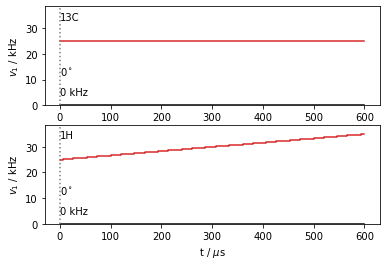

In [5]:
seq=L.Sequence()
seq.add_channel('13C',v1=25000)
t=L.dt*np.arange(30*3+1) #L.dt=L.taur/ex.n_gamma, 90 steps is 3 rotor periods (1 ms)
seq.add_channel('1H',t=t,v1=30000+np.linspace(-1,1,len(t))*5000) #ramp cp 
seq.plot()
U=seq.U()

Note, the propagator, `U`, isn't actually calculated until it's needed, so the above step is fast, whereas the calculation below is much slower. 

Take care with the order of operations below. Function calls precede mathematical operations, so that the call to `rho` inside the parenthesis is the first step executed, followed by multiplication of `rho` by `U`, and then another detecton is executed outside of the parenthesis. That is
```
(U*rho())()
```
is equivalent to
```
rho()
U*rho
rho()
```

In [6]:
(U*rho())()

Density Matrix/Detection Operator
rho0: 1Hx
detect[0]: 1Hx
detect[1]: 13Cx
Current time is 600.000 microseconds
2 time points have been recorded


Now we can check `rho.I` before and after CP.

In [7]:
print(f'1Hx : {rho.I[0][0].real:.2f}, {rho.I[0][1].real:.2}')
print(f'13Cx : {rho.I[1][0].real:.2f}, {rho.I[1][1].real:.2}')

1Hx : 1.00, 0.56
13Cx : 0.00, 0.31


We may also multiply the sequence by `rho`. First, we fully clear `rho`, to go back to the initial conditions. When multiplying a sequence by `rho`, the sequence uses its default length (`seq.Dt`) to produce a propagator, which is what actually gets multiplied by `rho`. This takes a little less code, but if the resulting propagator is discarded in this approach, so cannot be reused (which may or may not matter to the user).

In [8]:
rho.clear()
(seq*rho())()
print(f'1Hx : {rho.I[0][0].real:.2f}, {rho.I[0][1].real:.2}')
print(f'13Cx : {rho.I[1][0].real:.2f}, {rho.I[1][1].real:.2}')

1Hx : 1.00, 0.56
13Cx : 0.00, 0.31


## clear vs. reset

In the previous calculation, we cleared `rho`. This function takes `rho` back to its initial state (that is, as if it were just created). We also have the option to reset `rho`. This will bring the density matrix back to its initial state (`rho0`), but retain all the time points already stored in `rho`. Some pulse sequences, for example REDOR, DIPSHIFT, etc., require reseting rho to acquire the next time point, rather than just multiplying by the sequence or propagator again.

```
rho.clear() #Takes rho back to its inital state
rho.reset() #Resets the density matrix in rho back to rho0, but retains data in rho
```

We may also run

```
rho.clear(data_only=True) #Retains L and matrix reduction
```
which will keep the Liouvillian in `rho`, and also retain setup of matrix reduction.

Note that constant time experiments, where some terms evolve, but the total length of the experiment remains fixed, will result in `rho.t_axis` always having the same value. In this case, `rho` will not be able to determine the frequency axis of the Fourier transformed data. 

# Detect and Propagate (rho.DetProp)

In the above example, we get the magnetization before and after a ramped-CP step. However, it would be nice to also see what occurs during the CP. We could in principle do this by manually generating propagators over multiple steps through the sequence, and detecting in between, but we may also do this with the `rho.DetProp(...)` function and the sequence.

With `rho.DetProp()`, we provide a sequence or propagator and the number of times to detect and propagate (n; note that detection always comes first). We may also break up a sequence into parts, in this example, the number of steps equals the number of steps per sequence (`n_per_seq`), so we only go through the sequence once. Note, if a propagator is provided instead of a sequence, then we cannot use `n_per_seq`.

We choose 90 steps to match with the number of time points in the sequence, which should increase the calculation speed.

In [9]:
rho.clear()
_=rho.DetProp(seq,n=90,n_per_seq=90)

Prop: 90 steps per every 3 rotor periods


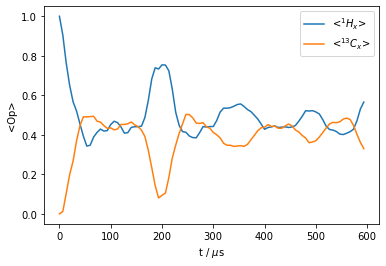

In [10]:
_=rho.plot()

Another good application of this approach is to simulate spinning sidebands. We use an emtpy sequence in this case (no RF-field applied).

In [11]:
rho=sl.Rho(rho0='13Cx',detect='13Cp')
seq=L.Sequence(cyclic=True).add_channel('13C',t=[0,L.taur/2,L.taur],v1=0)  #Default sequence with length taur
_=rho.DetProp(seq,n=20000,n_per_seq=20)
#8 steps per sequence gives us a spectral with 8 times the rotor frequency

State-space reduction: 16->2
Prop: 20 steps per every 1 rotor period


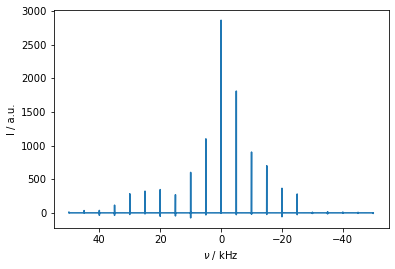

In [12]:
_=rho.plot(FT=True,apodize=False)

Aside from reducing coding, `rho.DetProp` has also executed a few computational speedups. First, it has identified that only 2 of the 16 spin-states would actually be accessed in this simulation, so it reduces the size of the matrix being propagated significantly. Second, it has performed the propagation in the eigenbasis. Note that because we have 20 steps per rotor period, 20 different eigenbases have been used, each corresponding to a different starting point in the rotor period. That is, we take 20 steps through the first rotor period. However, starting from each of those 20 steps, we then take rotor-period length steps, which can be propagated in the eigenbasis, vastly accelerating the computation time through the 20000 total timesteps (or 1000 steps per each starting point in the rotor period).

A final note: `rho` automatically returns a Fourier transformed signal, `rho.FT`. If `rho.apodize=False`, then this signal will only be zero-filled (to twice the original length), otherwise it will also be apodized. `rho.apod_pars` contains information on the window function and parameters, following Bruker Topspin convention. The `SI` parameter is set by default to None in `rho.apod_pars`, and will be internally set to twice the number of time domain signals. `LB` is also None and defaults to 5/(acquisition time$*\pi$)